<a href="https://colab.research.google.com/github/magomeda228/Colab_Google_ML_H-W/blob/main/Gradient_Descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
%%writefile descents.py
from dataclasses import dataclass
from enum import auto
from enum import Enum
from typing import Dict
from typing import Type
import pandas as pd
import numpy as np
import scipy
import scipy.sparse


@dataclass
class LearningRate:
    lambda_: float = 1e-3
    s0: float = 1
    p: float = 0.5

    iteration: int = 0

    def __call__(self):
        """
        Calculate learning rate according to lambda (s0/(s0 + t))^p formula
        """
        self.iteration += 1
        return self.lambda_ * (self.s0 / (self.s0 + self.iteration)) ** self.p


class LossFunction(Enum):
    MSE = auto()
    MAE = auto()
    LogCosh = auto()
    Huber = auto()


class BaseDescent:
    """
    A base class and templates for all functions
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        """
        :param dimension: feature space dimension
        :param lambda_: learning rate parameter
        :param loss_function: optimized loss function
        """
        self.delta: float = 1.0
        self.w: np.ndarray = np.random.rand(dimension)
        self.lr: LearningRate = LearningRate(lambda_=lambda_)
        self.loss_function: LossFunction = loss_function

    def step(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.update_weights(self.calc_gradient(x, y))

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        if self.loss_function is LossFunction.MSE:
            return self._mse_gradient(x, y)
        elif self.loss_function is LossFunction.LogCosh:
            return self._log_cosh_gradient(x, y)
        elif self.loss_function is LossFunction.MAE:
            return self._mae_gradient(x, y)
        elif self.loss_function is LossFunction.Huber:
            return self._huber_gradient(x, y)

    def _mse_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Compute the gradient for Mean Squared Error loss.
        """
        return -2 / x.shape[0] * x.T @ (y - x @ self.w)

    def _log_cosh_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        predict = self.predict(x)
        gradient = np.tanh(predict - y)
        return gradient / y.shape[0]

    def _mae_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        gradient = np.zeros_like(self.predict(x))
        gradient[self.predict(x) > y] = 1 / y.shape[0]
        gradient[self.predict(x) < y] = -1 / y.shape[0]
        return gradient / y.shape[0]

    def _huber_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        error = y - self.predict(x)
        is_small_error = np.abs(error) <= self.delta
        squared_loss = 0.5 * error ** 2
        linear_loss = self.delta * (np.abs(error) - 0.5 * self.delta)
        return np.where(is_small_error, squared_loss, linear_loss).mean()

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        Template for update_weights function
        Update weights with respect to gradient
        :param gradient: gradient
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        delta_w = -self.lr() * gradient
        self.w += delta_w
        return delta_w


    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Template for calc_gradient function
        Calculate gradient of loss function with respect to weights
        :param x: features array
        :param y: targets array
        :return: gradient: np.ndarray
        """
        return -2/x.shape[0] * x.T @(y - x @ self.w)


    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculate loss for x and y with our weights
        :param x: features array
        :param y: targets array
        :return: loss: float
        """
        return 1 / x.shape[0] * (y - x @ self.w).T @ (y - x @ self.w)
        # TODO: implement loss calculation function
#        raise NotImplementedError('BaseDescent calc_loss function not implemented')

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Calculate predictions for x
        :param x: features array
        :return: prediction: np.ndarray
        """
        return x @ self.w
        # TODO: implement prediction function
        #raise NotImplementedError('BaseDescent predict function not implemented')


class VanillaGradientDescent(BaseDescent):
    """
    Full gradient descent class
    """
    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        Update weights with respect to gradient
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        delta_w = self.lr() * gradient
        self.w -= delta_w
        return delta_w
        # TODO: implement updating weights function
        # raise NotImplementedError('VanillaGradientDescent update_weights function not implemented')

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:

        return (- 1/ y.shape[0]) * x.T @ (y - x @ self.w)
       # raise NotImplementedError('VanillaGradientDescent calc_gradient function not implemented')


class StochasticDescent(VanillaGradientDescent):
    """
    Stochastic gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, batch_size: int = 50,
                 loss_function: LossFunction = LossFunction.MSE):
        """
        :param batch_size: batch size (int)
        """
        super().__init__(dimension, lambda_, loss_function)
        self.batch_size = batch_size

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        # TODO: implement calculating gradient function
        if isinstance(x, pd.DataFrame) or isinstance(x, pd.Series):
         x = x.reset_index(drop=True).to_numpy()
        if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
         y = y.reset_index(drop=True).to_numpy()
        batch_indices = np.random.randint(0, x.shape[0], self.batch_size)
        x_batch = x[batch_indices]
        y_batch = y[batch_indices]
        if self.batch_size > y.shape[0]:
          raise ValueError("Batch soze can't exceed dataset size")
        return (- 1/ self.batch_size) * x_batch.T @ (y_batch - x_batch @ self.w)
        #raise NotImplementedError('StochasticDescent calc_gradient function not implemented')


class MomentumDescent(VanillaGradientDescent):
    """
    Momentum gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.alpha: float = 0.9

        self.h: np.ndarray = np.zeros(dimension)

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        Update weights with respect to gradient
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        self.h = self.alpha * self.h + self.lr() * gradient
        self.w -= self.h
        delta_w = -self.h
        return delta_w
        # TODO: implement updating weights function
        # raise NotImplementedError('MomentumDescent update_weights function not implemented')


class Adam(VanillaGradientDescent):
    """
    Adaptive Moment Estimation gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.eps: float = 1e-9

        self.m: np.ndarray = np.zeros(dimension)
        self.v: np.ndarray = np.zeros(dimension)

        self.beta_1: float = 0.9
        self.beta_2: float = 0.999
        #self.iteration: int = 0

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        Update weights & params
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        #print(f"lr.iteration:{LearningRate(lambda_).iteration} try")
        iteration = self.lr.iteration
        self.m = self.beta_1 * self.m + (1 - self.beta_1) * gradient
        self.v = self.beta_2 * self.v + (1 - self.beta_2) * gradient ** 2

        m_ = self.m / (1 - self.beta_1 ** (iteration  + 1 ))
        v_ = self.v / (1 - self.beta_2 ** (iteration  + 1 ))
        if np.any(np.isnan(m_)) or np.any(np.isnan(v_)):
          raise ValueError(f"Nan detected in Adam opitimizations self iteration:{iteration}")
        delta_w = -self.lr() * m_ /(np.sqrt(v_)  + self.eps)
        self.w -= delta_w
        return delta_w
        # TODO: implement updating weights function
        # raise NotImplementedError('Adagrad update_weights function not implemented')


class BaseDescentReg(BaseDescent):
    """
    A base class with regularization
    """

    def __init__(self, *args, mu: float = 0, **kwargs):
        """
        :param mu: regularization coefficient (float)
        """
        super().__init__(*args, **kwargs)

        self.mu = mu

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Calculate gradient of loss function and L2 regularization with respect to weights
        """
        if isinstance(x, (np.ndarray, pd.DataFrame)):
          x = x.to_numpy()
        elif isinstance(x, scipy.sparse.spmatrix):
          x = x.toarray()

        if isinstance(y, (np.ndarray, pd.DataFrame)):
          y = y.to_numpy()
        elif isinstance(y, scipy.sparse.spmatrix):
          y = y.toarray()
        l2_gradient: np.ndarray = 2 * self.w  # TODO: replace with L2 gradient calculation

        return super().calc_gradient(x, y) + l2_gradient * self.mu


class VanillaGradientDescentReg(BaseDescentReg, VanillaGradientDescent):
    """
    Full gradient descent with regularization class
    """


class StochasticDescentReg(BaseDescentReg, StochasticDescent):
    """
    Stochastic gradient descent with regularization class
    """


class MomentumDescentReg(BaseDescentReg, MomentumDescent):
    """
    Momentum gradient descent with regularization class
    """


class AdamReg(BaseDescentReg, Adam):
    """
    Adaptive gradient algorithm with regularization class
    """


def get_descent(descent_config: dict) -> BaseDescent:
    descent_name = descent_config.get('descent_name', 'full')
    regularized = descent_config.get('regularized', False)

    descent_mapping: Dict[str, Type[BaseDescent]] = {
        'full': VanillaGradientDescent if not regularized else VanillaGradientDescentReg,
        'stochastic': StochasticDescent if not regularized else StochasticDescentReg,
        'momentum': MomentumDescent if not regularized else MomentumDescentReg,
        'adam': Adam if not regularized else AdamReg,
        'descent': BaseDescent if not regularized else BaseDescentReg
    }

    if descent_name not in descent_mapping:
        raise ValueError(f'Incorrect descent name, use one of these: {descent_mapping.keys()}')

    descent_class = descent_mapping[descent_name]

    return descent_class(**descent_config.get('kwargs', {}))

Overwriting descents.py


In [46]:
from __future__ import annotations

from typing import List

import numpy as np

from descents import BaseDescent
from descents import get_descent
import importlib
import descents

importlib.reload(descents)

class LinearRegression:
    """
    Linear regression class
    """

    def __init__(self, descent_config: dict, tolerance: float = 1e-4, max_iter: int = 300):
        """
        :param descent_config: gradient descent config
        :param tolerance: stopping criterion for square of euclidean norm of weight difference (float)
        :param max_iter: stopping criterion for iterations (int)
        """
        self.descent: BaseDescent = get_descent(descent_config)

        self.tolerance: float = tolerance
        self.max_iter: int = max_iter

        self.loss_history: List[float] = []

    def fit(self, x: np.ndarray, y: np.ndarray) -> LinearRegression:
        """
        Fitting descent weights for x and y dataset
        :param x: features array
        :param y: targets array
        :return: self
        """
        i = 0
        gradient = self.descent.calc_gradient(x, y)
        delta_w = self.descent.update_weights(gradient)
        self.loss_history.append(self.calc_loss(x, y))
        while (i < self.max_iter) and (np.linalg.norm(delta_w) > self.tolerance):
          i+=1
          gradient = self.descent.calc_gradient(x, y)
          delta_w = self.descent.update_weights(gradient)
          self.loss_history.append(self.calc_loss(x, y))
        # TODO: fit weights to x and y
        return self
        #raise NotImplementedError('LinearRegression fit function not implemented')

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Predicting targets for x dataset
        :param x: features array
        :return: prediction: np.ndarray
        """
        return self.descent.predict(x)

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating loss for x and y dataset
        :param x: features array
        :param y: targets array
        """
        return self.descent.calc_loss(x, y)


In [6]:
with open("linear_regression.py", "w") as f:
    f.write("""
from __future__ import annotations

from typing import List

import numpy as np

from descents import BaseDescent
from descents import get_descent
import importlib
import descents

importlib.reload(descents)

class LinearRegression:

        def __init__(self, descent_config: dict, tolerance: float = 1e-4, max_iter: int = 300):
            self.descent: BaseDescent = get_descent(descent_config)
            self.tolerance: float = tolerance
            self.max_iter: int = max_iter
            self.loss_history: List[float] = []
        def fit(self, x: np.ndarray, y: np.ndarray) -> LinearRegression:
            i = 0
            gradient = self.descent.calc_gradient(x, y)
            delta_w = self.descent.update_weights(gradient)
            self.loss_history.append(self.calc_loss(x, y))
            while (i < self.max_iter) and (np.linalg.norm(delta_w) > self.tolerance):
              i+=1
              gradient = self.descent.calc_gradient(x, y)
              delta_w = self.descent.update_weights(gradient)
              self.loss_history.append(self.calc_loss(x, y))
            return self

        def predict(self, x: np.ndarray) -> np.ndarray:
            return self.descent.predict(x)

        def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
            return self.descent.calc_loss(x, y)
    """)

In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np

from descents import get_descent
from linear_regression import LinearRegression
num_objects = 100
dimension = 5

x = np.random.rand(num_objects, dimension)
y = np.random.rand(num_objects)
# Descents

descent_config = {
    'descent_name': 'some name that we will replace in the future',
    'kwargs': {
        'dimension': dimension
    }
}

for descent_name in ['full', 'stochastic', 'momentum', 'adam']:
    descent_config['descent_name'] = descent_name
    descent = get_descent(descent_config)

    diff = descent.step(x, y)
    gradient = descent.calc_gradient(x, y)
    predictions = descent.predict(x)

    assert gradient.shape[0] == dimension, f'Gradient failed for descent {descent_name}'
    assert diff.shape[0] == dimension, f'Weights failed for descent {descent_name}'
    assert predictions.shape == y.shape, f'Prediction failed for descent {descent_name}'

In [8]:
# LinearRegression

max_iter = 10
tolerance = 0

descent_config = {
    'descent_name': 'stochastic',
    'kwargs': {
        'dimension': dimension,
        'batch_size': 10
    }
}

regression = LinearRegression(
    descent_config=descent_config,
    tolerance=tolerance,
    max_iter=max_iter
)

regression.fit(x, y)

assert len(regression.loss_history) == max_iter + 1, 'Loss history failed'

Как показали тесты выполнение кода по реализации методов: VanillaGradientDescent, StochasticDescent, MomentumDescent, Adam, LinearRegression совершена успешно.

In [9]:
import numpy as np
import pandas as pd  # при желании, можете заменить на polars/pyspark или что угодно, что вам нравится

import matplotlib.pyplot as plt
import seaborn as sns

from descents import get_descent
from linear_regression import LinearRegression

sns.set(style='darkgrid')

In [10]:
!wget -O 'autos.csv' -q 'https://raw.githubusercontent.com/esokolov/ml-course-hse/master/2024-fall/homework-practice/homework-practice-03-gd/autos.csv'


In [11]:
data = pd.read_csv('autos.csv')

In [12]:
data.head()

,brand,model,vehicleType,gearbox,fuelType,notRepairedDamage,powerPS,kilometer,autoAgeMonths,price
0,volkswagen,golf,kleinwagen,manuell,benzin,nein,75,150000,177,1500
1,skoda,fabia,kleinwagen,manuell,diesel,nein,69,90000,93,3600
2,bmw,3er,limousine,manuell,benzin,ja,102,150000,246,650
3,peugeot,2_reihe,cabrio,manuell,benzin,nein,109,150000,140,2200
4,mazda,3_reihe,limousine,manuell,benzin,nein,105,150000,136,2000


In [13]:
categorical = []
numeric = []
other = []
categorical = data.select_dtypes(include=['object', 'string']).columns.tolist()
numeric = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [14]:
data['bias'] = 1
other += ['bias']
sum_col = categorical + numeric + other
x = data[categorical + numeric + other]
y = data['price']


In [15]:
sum_col = categorical + numeric + other
x = data[categorical + numeric + other]
y = data['price']

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric),
    ('other',  'passthrough', other)
])

x = column_transformer.fit_transform(x)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [18]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [19]:
lambdas = np.logspace(-10, 1, num = 12)

In [20]:
methods = ['full','stochastic','momentum','adam']


In [21]:
r2_dat, r3_dat = [], []

In [ ]:
for method in methods:
  for lambda_ in lambdas:
    descent_config = {
            'descent_name': method,  # Название метода: 'full', 'stochastic', 'momentum', 'adam'
            'regularized': False,    # Указать, использовать ли регуляризацию
            'kwargs': {              # Дополнительные параметры для метода
            'dimension': X_train.shape[1],  # Размерность входных данных
            'lambda_': lambda_  # Текущее значение learning rate
             }}

    model = get_descent(descent_config)

    max_iter = 1000
    tolerance = 0.1
    for iter in range(max_iter):
      gradient = model.calc_gradient(X_val, y_val)
      delta_w = model.update_weights(gradient)
      if np.linalg.norm(delta_w) < tolerance:
        break

    y_val_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_val_pred)
    r2_dat.append(r2)
    print(f"method: {method}, r2: {r2}, lambda: {lambda_}")

method: full, r2: -0.7305718037835949, lambda: 1e-10
method: full, r2: -0.7305794327325581, lambda: 1e-09
method: full, r2: -0.730622323943346, lambda: 1e-08
method: full, r2: -0.730796336900206, lambda: 1e-07
method: full, r2: -0.7301174705316387, lambda: 1e-06
method: full, r2: -0.7255634081710478, lambda: 1e-05
method: full, r2: -0.6805511568476799, lambda: 0.0001
method: full, r2: -0.2958146344805108, lambda: 0.001
method: full, r2: 0.8074095705378698, lambda: 0.01
method: full, r2: 0.9909641686485561, lambda: 0.1
method: full, r2: 0.9999040659279431, lambda: 1.0
method: full, r2: -7.338540737871921e+151, lambda: 10.0
method: stochastic, r2: -0.7305697642125191, lambda: 1e-10
method: stochastic, r2: -0.7306257383556065, lambda: 1e-09
method: stochastic, r2: -0.7307988360572322, lambda: 1e-08
method: stochastic, r2: -0.7305830689708681, lambda: 1e-07
method: stochastic, r2: -0.7303700625079816, lambda: 1e-06
method: stochastic, r2: -0.7254531599587926, lambda: 1e-05
method: stochast

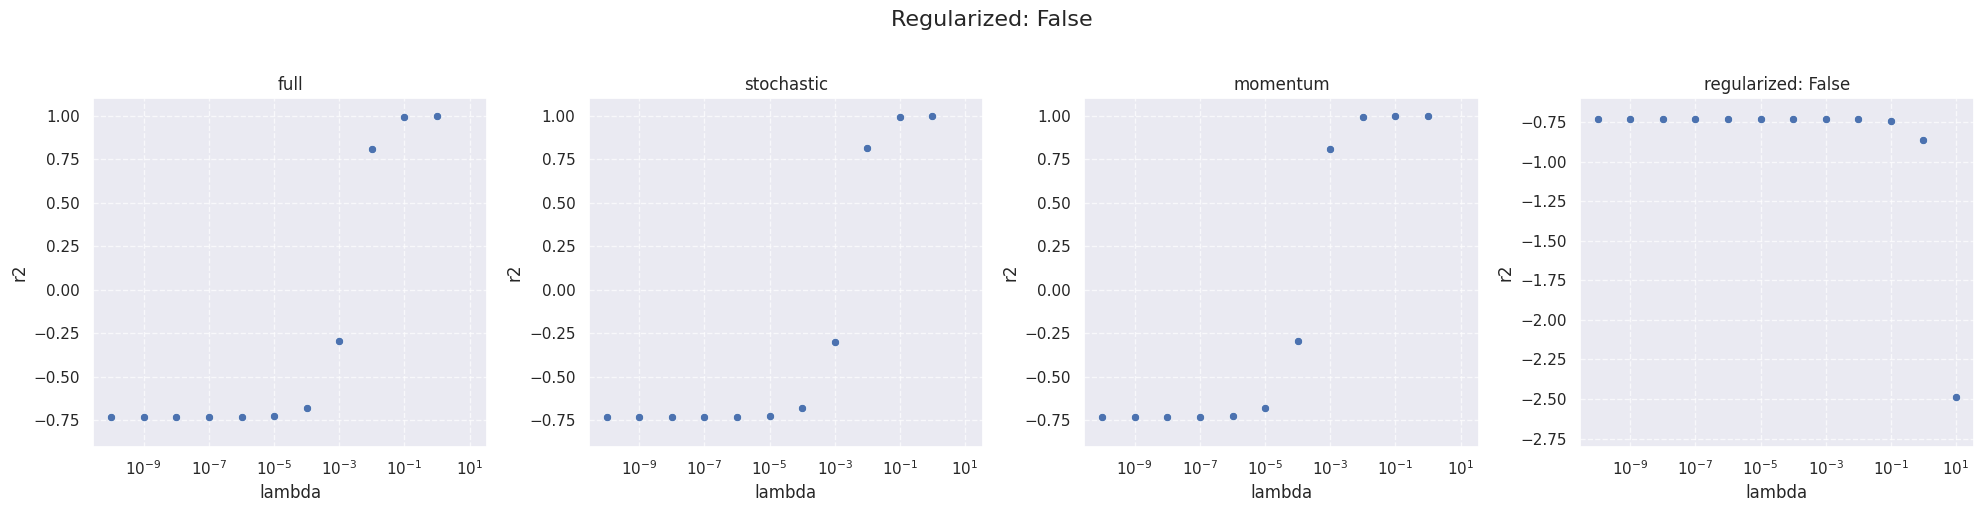

In [ ]:
x = np.logspace(-10, 1, num=12)
y = np.array(r2_dat).reshape(4, -1)
fig, ax = plt.subplots(1, 4, figsize=(20,5))
name = ['full','stochastic','momentum','adam']
for j in range(4):
  sns.scatterplot(x = x, y = y[j], ax=ax[j])
  ax[j].set_xscale('log')
  ax[j].set_ylabel('r2')
  ax[j].set_xlabel('lambda')
  ax[j].grid(True, linestyle='--', alpha=0.7)
  ax[j].set_title(name[j])
  if j<3:
    ax[j].set_ylim(-0.9, 1.1)
  else:
    ax[j].set_ylim(-2.8, -0.6)
plt.title('regularized: False')
fig.suptitle('Regularized: False', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
len(r3_dat)

113

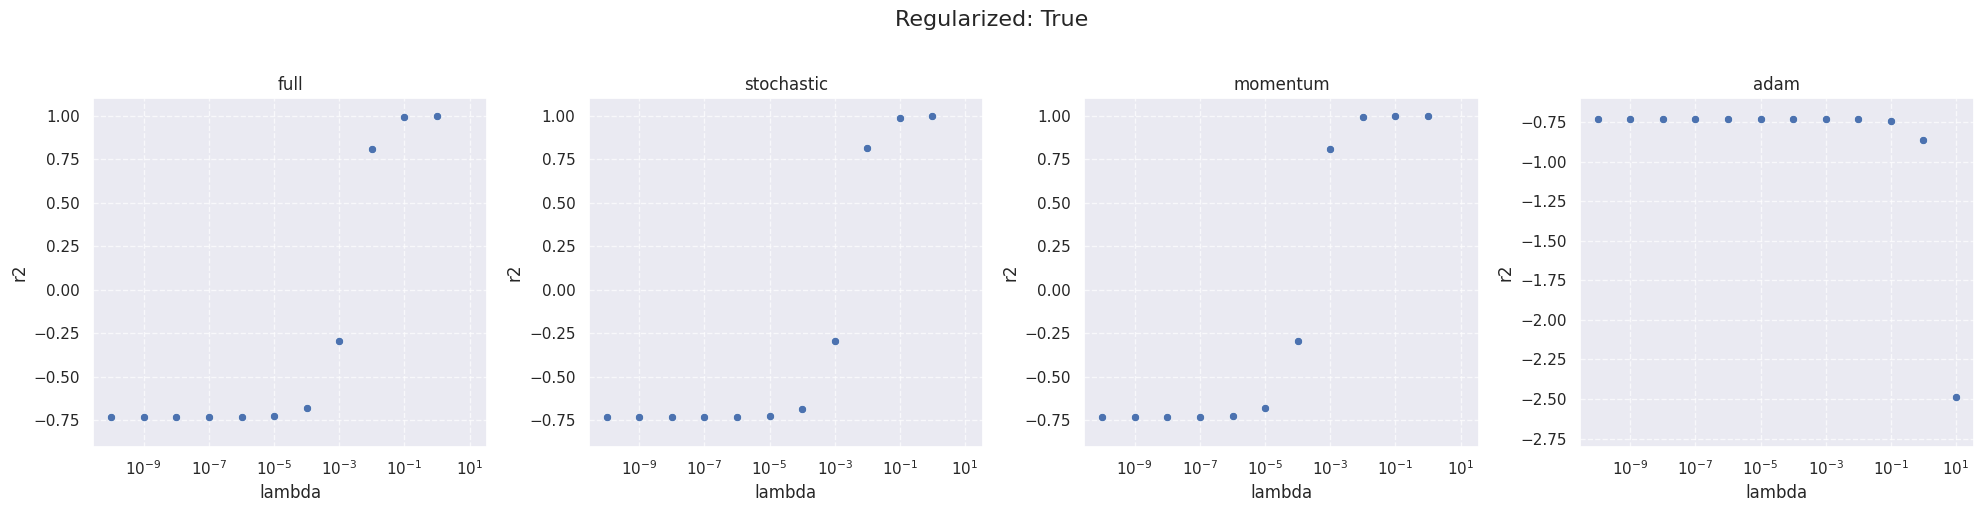

In [ ]:
x = np.logspace(-10, 1, num=12)
y = np.array(r3_dat).reshape(4, -1)
fig, ax = plt.subplots(1, 4, figsize=(20,5))
name = ['full','stochastic','momentum','adam']
for j in range(4):
  sns.scatterplot(x = x, y = y[j], ax=ax[j])
  ax[j].set_xscale('log')
  ax[j].set_ylabel('r2')
  ax[j].set_xlabel('lambda')
  ax[j].grid(True, linestyle='--', alpha=0.7)
  ax[j].set_title(name[j])
  if j<3:
    ax[j].set_ylim(-0.9, 1.1)
  else:
    ax[j].set_ylim(-2.8, -0.6)
fig.suptitle('Regularized: False', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [22]:
r2_dat_stochastic, num_iter, duration = [], [], []

In [23]:
import time

In [24]:
batch_sizes = np.arange(5, 500, 10)
for batch_size in batch_sizes:
  descent_config = {
              'descent_name': 'stochastic',
              'regularized': True,    # Указать, использовать ли регуляризацию
              'kwargs': {              # Дополнительные параметры для метода
              'dimension': X_train.shape[1],  # Размерность входных данных
              'lambda_': 0.1,
              'batch_size': batch_size                       # Текущее значение learning rate
              }}

  model = get_descent(descent_config)

  max_iter = 100000
  tolerance = 1e-2
  start_time = time.time()
  i = 0
  for iter in range(max_iter):
    gradient = model.calc_gradient(X_val, y_val)
    delta_w = model.update_weights(gradient)
    i+=1
    if np.linalg.norm(delta_w) < tolerance:
      break

  end_time = time.time()
  num_iter.append(i)
  duration.append(end_time - start_time)
  y_val_pred = model.predict(X_val)
  r2 = r2_score(y_val, y_val_pred)
  r2_dat_stochastic.append(r2)
  print(f"method: stochastic, r2: {r2}, batch_size: {batch_size}, time: {end_time - start_time}, num_iter: {i}")

KeyboardInterrupt: 

In [ ]:
len(num_iter)

50

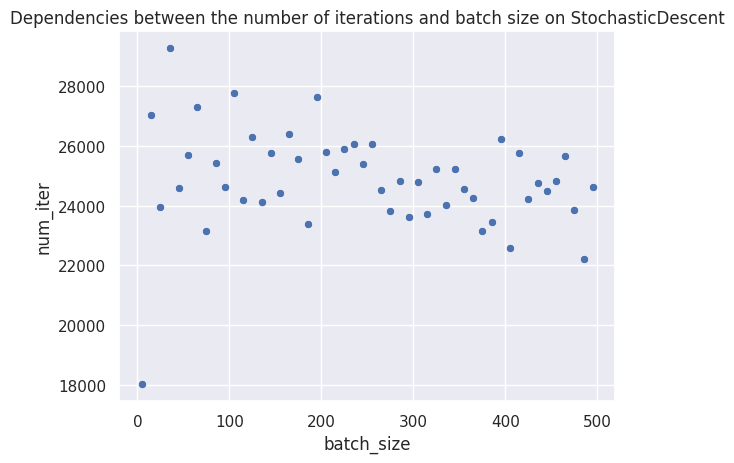

In [ ]:

sns.scatterplot(x = batch_sizes, y = num_iter)
plt.ylabel('num_iter')
plt.xlabel('batch_size')
plt.title('Dependencies between the number of iterations and batch size on StochasticDescent')
plt.show()

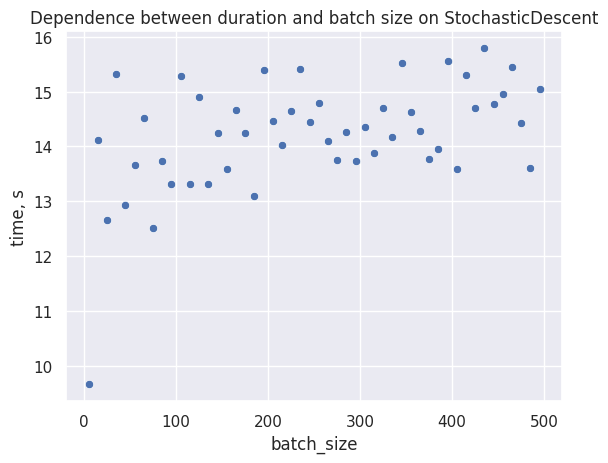

In [ ]:
sns.scatterplot(x = batch_sizes, y = duration)
plt.xlabel('batch_size')
plt.ylabel('time, s')
plt.title('Dependence between duration and batch size on StochasticDescent')
plt.show()

In [29]:
mus = np.logspace(-4, 0, 5)

In [30]:
mus

array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])

In [37]:
lambdas = np.logspace(-10,0,11)

In [26]:
methods = ['full','stochastic','momentum','adam', 'descent']

In [39]:
r2_dat_reg = []

In [40]:
for method in methods:
  for mu in mus:
    for lambda_ in lambdas:
      descent_config = {
              'descent_name': method,  # Название метода: 'full', 'stochastic', 'momentum', 'adam'
              'regularized': True,    # Указать, использовать ли регуляризацию
              'kwargs': {              # Дополнительные параметры для метода
              'dimension': X_train.shape[1],  # Размерность входных данных
              'lambda_': lambda_,
              'mu': mu                        # Текущее значение learning rate
              }}

      model = get_descent(descent_config)

      max_iter = 500
      tolerance = 0.1
      for iter in range(max_iter):
        gradient = model.calc_gradient(X_val, y_val)
        delta_w = model.update_weights(gradient)
        if np.linalg.norm(delta_w) < tolerance:
          break
        #print(f"np.linalg.norm(delta_w): {np.linalg.norm(delta_w)}")
      y_val_pred = model.predict(X_val)
      r2 = r2_score(y_val, y_val_pred)
      r2_dat_reg.append(r2)
      print(f"method: {descent_config.get('descent_name')}, r2: {r2}, lambda: {lambda_}, mu: {mu}")

method: full, r2: -0.7307983696335929, lambda: 1e-10, mu: 0.0001
method: full, r2: -0.7307255219393216, lambda: 1e-09, mu: 0.0001
method: full, r2: -0.7307073825219221, lambda: 1e-08, mu: 0.0001
method: full, r2: -0.7304249324835226, lambda: 1e-07, mu: 0.0001
method: full, r2: -0.7307229240051063, lambda: 1e-06, mu: 0.0001
method: full, r2: -0.7306726053933914, lambda: 1e-05, mu: 0.0001
method: full, r2: -0.7055431480766308, lambda: 0.0001, mu: 0.0001
method: full, r2: -0.4131010132864372, lambda: 0.001, mu: 0.0001
method: full, r2: 0.6873543531703343, lambda: 0.01, mu: 0.0001
method: full, r2: 0.9806947948158965, lambda: 0.1, mu: 0.0001
method: full, r2: 0.9998371618531139, lambda: 1.0, mu: 0.0001
method: full, r2: -0.7305039451739876, lambda: 1e-10, mu: 0.001
method: full, r2: -0.7305901939861235, lambda: 1e-09, mu: 0.001
method: full, r2: -0.7306484334962282, lambda: 1e-08, mu: 0.001
method: full, r2: -0.7307005877013599, lambda: 1e-07, mu: 0.001
method: full, r2: -0.730886277139639

KeyboardInterrupt: 

Импортрование сохраненных данных r2_dat_reg (в силу случайного запуска графика для Momentum и сброса кеша) и извлечение значений r2 по причине отсуствия желания повторого запуска кода на 3 часа.......

In [129]:
data = """r2: -0.7307983696335929, lambda: 1e-10, mu: 0.0001
method: full, r2: -0.7307255219393216, lambda: 1e-09, mu: 0.0001
method: full, r2: -0.7307073825219221, lambda: 1e-08, mu: 0.0001
method: full, r2: -0.7304249324835226, lambda: 1e-07, mu: 0.0001
method: full, r2: -0.7307229240051063, lambda: 1e-06, mu: 0.0001
method: full, r2: -0.7306726053933914, lambda: 1e-05, mu: 0.0001
method: full, r2: -0.7055431480766308, lambda: 0.0001, mu: 0.0001
method: full, r2: -0.4131010132864372, lambda: 0.001, mu: 0.0001
method: full, r2: 0.6873543531703343, lambda: 0.01, mu: 0.0001
method: full, r2: 0.9806947948158965, lambda: 0.1, mu: 0.0001
method: full, r2: 0.9998371618531139, lambda: 1.0, mu: 0.0001
method: full, r2: -0.7305039451739876, lambda: 1e-10, mu: 0.001
method: full, r2: -0.7305901939861235, lambda: 1e-09, mu: 0.001
method: full, r2: -0.7306484334962282, lambda: 1e-08, mu: 0.001
method: full, r2: -0.7307005877013599, lambda: 1e-07, mu: 0.001
method: full, r2: -0.7308862771396394, lambda: 1e-06, mu: 0.001
method: full, r2: -0.7306768172420555, lambda: 1e-05, mu: 0.001
method: full, r2: -0.7054525246859586, lambda: 0.0001, mu: 0.001
method: full, r2: -0.4129669168911816, lambda: 0.001, mu: 0.001
method: full, r2: 0.6871086268015661, lambda: 0.01, mu: 0.001
method: full, r2: 0.980489330027097, lambda: 0.1, mu: 0.001
method: full, r2: 0.9998122402489582, lambda: 1.0, mu: 0.001
method: full, r2: -0.7307269515478496, lambda: 1e-10, mu: 0.01
method: full, r2: -0.7306663246215779, lambda: 1e-09, mu: 0.01
method: full, r2: -0.7306446908603996, lambda: 1e-08, mu: 0.01
method: full, r2: -0.7305315914005164, lambda: 1e-07, mu: 0.01
method: full, r2: -0.7307060435471797, lambda: 1e-06, mu: 0.01
method: full, r2: -0.7305932521886658, lambda: 1e-05, mu: 0.01
method: full, r2: -0.7053606532991901, lambda: 0.0001, mu: 0.01
method: full, r2: -0.41316374905320385, lambda: 0.001, mu: 0.01
method: full, r2: 0.6847981642020434, lambda: 0.01, mu: 0.01
method: full, r2: 0.9783292673192804, lambda: 0.1, mu: 0.01
method: full, r2: 0.9986757727241746, lambda: 1.0, mu: 0.01
method: full, r2: -0.7306076007681876, lambda: 1e-10, mu: 0.1
method: full, r2: -0.7306345517625614, lambda: 1e-09, mu: 0.1
method: full, r2: -0.730634852074598, lambda: 1e-08, mu: 0.1
method: full, r2: -0.7304343059880869, lambda: 1e-07, mu: 0.1
method: full, r2: -0.7307136513552037, lambda: 1e-06, mu: 0.1
method: full, r2: -0.7306602082072102, lambda: 1e-05, mu: 0.1
method: full, r2: -0.7054232295075349, lambda: 0.0001, mu: 0.1
method: full, r2: -0.4143464120547702, lambda: 0.001, mu: 0.1
method: full, r2: 0.6622265070630232, lambda: 0.01, mu: 0.1
method: full, r2: 0.9487571501087746, lambda: 0.1, mu: 0.1
method: full, r2: 0.9602632980161881, lambda: 1.0, mu: 0.1
method: full, r2: -0.7305250425430965, lambda: 1e-10, mu: 1.0
method: full, r2: -0.7307048297207055, lambda: 1e-09, mu: 1.0
method: full, r2: -0.7307180705490548, lambda: 1e-08, mu: 1.0
method: full, r2: -0.7307819321637192, lambda: 1e-07, mu: 1.0
method: full, r2: -0.7305235146359306, lambda: 1e-06, mu: 1.0
method: full, r2: -0.7304024332182035, lambda: 1e-05, mu: 1.0
method: full, r2: -0.7057378204600768, lambda: 0.0001, mu: 1.0
method: full, r2: -0.42522880456150625, lambda: 0.001, mu: 1.0
method: full, r2: 0.4388055261190985, lambda: 0.01, mu: 1.0
method: full, r2: 0.5714925447663176, lambda: 0.1, mu: 1.0
method: full, r2: 0.5717654898908826, lambda: 1.0, mu: 1.0
method: stochastic, r2: -0.7307488776817901, lambda: 1e-10, mu: 0.0001
method: stochastic, r2: -0.7307157556706656, lambda: 1e-09, mu: 0.0001
method: stochastic, r2: -0.7308635717927616, lambda: 1e-08, mu: 0.0001
method: stochastic, r2: -0.7306056861826062, lambda: 1e-07, mu: 0.0001
method: stochastic, r2: -0.7303545426525342, lambda: 1e-06, mu: 0.0001
method: stochastic, r2: -0.7307140716439742, lambda: 1e-05, mu: 0.0001
method: stochastic, r2: -0.7142506476842201, lambda: 0.0001, mu: 0.0001
method: stochastic, r2: -0.40686596495015825, lambda: 0.001, mu: 0.0001
method: stochastic, r2: 0.702046406677215, lambda: 0.01, mu: 0.0001
method: stochastic, r2: 0.9821115890032951, lambda: 0.1, mu: 0.0001
method: stochastic, r2: 0.9997642072460595, lambda: 1.0, mu: 0.0001
method: stochastic, r2: -0.7306727298835016, lambda: 1e-10, mu: 0.001
method: stochastic, r2: -0.7309194614367742, lambda: 1e-09, mu: 0.001
method: stochastic, r2: -0.7307288948018023, lambda: 1e-08, mu: 0.001
method: stochastic, r2: -0.7304166915994958, lambda: 1e-07, mu: 0.001
method: stochastic, r2: -0.7306281520265572, lambda: 1e-06, mu: 0.001
method: stochastic, r2: -0.730460458823565, lambda: 1e-05, mu: 0.001
method: stochastic, r2: -0.7137984266116917, lambda: 0.0001, mu: 0.001
method: stochastic, r2: -0.40823156121012616, lambda: 0.001, mu: 0.001
method: stochastic, r2: 0.6894022676170777, lambda: 0.01, mu: 0.001
method: stochastic, r2: 0.9813898803769998, lambda: 0.1, mu: 0.001
method: stochastic, r2: 0.9996706475280003, lambda: 1.0, mu: 0.001
method: stochastic, r2: -0.7305986378395106, lambda: 1e-10, mu: 0.01
method: stochastic, r2: -0.7306796573380396, lambda: 1e-09, mu: 0.01
method: stochastic, r2: -0.7307225779099715, lambda: 1e-08, mu: 0.01
method: stochastic, r2: -0.7304993001855327, lambda: 1e-07, mu: 0.01
method: stochastic, r2: -0.7309584258224238, lambda: 1e-06, mu: 0.01
method: stochastic, r2: -0.7305388308428882, lambda: 1e-05, mu: 0.01
method: stochastic, r2: -0.7141129093182288, lambda: 0.0001, mu: 0.01
method: stochastic, r2: -0.41777417646714654, lambda: 0.001, mu: 0.01
method: stochastic, r2: 0.6787561686753625, lambda: 0.01, mu: 0.01
method: stochastic, r2: 0.9779778158421033, lambda: 0.1, mu: 0.01
method: stochastic, r2: 0.9984650055299983, lambda: 1.0, mu: 0.01
method: stochastic, r2: -0.7304236906527393, lambda: 1e-10, mu: 0.1
method: stochastic, r2: -0.7307831042837616, lambda: 1e-09, mu: 0.1
method: stochastic, r2: -0.7304291027870389, lambda: 1e-08, mu: 0.1
method: stochastic, r2: -0.7307087124238123, lambda: 1e-07, mu: 0.1
method: stochastic, r2: -0.7307193933952632, lambda: 1e-06, mu: 0.1
method: stochastic, r2: -0.7307532272888921, lambda: 1e-05, mu: 0.1
method: stochastic, r2: -0.715027863891941, lambda: 0.0001, mu: 0.1
method: stochastic, r2: -0.41543388254322045, lambda: 0.001, mu: 0.1
method: stochastic, r2: 0.6460871909318526, lambda: 0.01, mu: 0.1
method: stochastic, r2: 0.9489477020590101, lambda: 0.1, mu: 0.1
method: stochastic, r2: 0.9539190093501678, lambda: 1.0, mu: 0.1
method: stochastic, r2: -0.7305166050135108, lambda: 1e-10, mu: 1.0
method: stochastic, r2: -0.7310463880394706, lambda: 1e-09, mu: 1.0
method: stochastic, r2: -0.7306551053047212, lambda: 1e-08, mu: 1.0
method: stochastic, r2: -0.7305551188200223, lambda: 1e-07, mu: 1.0
method: stochastic, r2: -0.7306540841518496, lambda: 1e-06, mu: 1.0
method: stochastic, r2: -0.7304807787321002, lambda: 1e-05, mu: 1.0
method: stochastic, r2: -0.713656644264937, lambda: 0.0001, mu: 1.0
method: stochastic, r2: -0.41928745997672556, lambda: 0.001, mu: 1.0
method: stochastic, r2: 0.4354970666583592, lambda: 0.01, mu: 1.0
method: stochastic, r2: 0.5728953910808743, lambda: 0.1, mu: 1.0
method: stochastic, r2: 0.565003427254964, lambda: 1.0, mu: 1.0
method: momentum, r2: -0.73081508643204, lambda: 1e-10, mu: 0.0001
method: momentum, r2: -0.7309524286849727, lambda: 1e-09, mu: 0.0001
method: momentum, r2: -0.7303874129960477, lambda: 1e-08, mu: 0.0001
method: momentum, r2: -0.7304523926209594, lambda: 1e-07, mu: 0.0001
method: momentum, r2: -0.7304747807295549, lambda: 1e-06, mu: 0.0001
method: momentum, r2: -0.7053042107984147, lambda: 1e-05, mu: 0.0001
method: momentum, r2: -0.415134635367024, lambda: 0.0001, mu: 0.0001
method: momentum, r2: 0.6935707565388305, lambda: 0.001, mu: 0.0001
method: momentum, r2: 0.9813021742815444, lambda: 0.01, mu: 0.0001
method: momentum, r2: 0.999840449738113, lambda: 0.1, mu: 0.0001
method: momentum, r2: 0.9999922766995109, lambda: 1.0, mu: 0.0001
method: momentum, r2: -0.7309658232149325, lambda: 1e-10, mu: 0.001
method: momentum, r2: -0.7305975856279021, lambda: 1e-09, mu: 0.001
method: momentum, r2: -0.7306691678869348, lambda: 1e-08, mu: 0.001
method: momentum, r2: -0.730507993043118, lambda: 1e-07, mu: 0.001
method: momentum, r2: -0.7307067464353101, lambda: 1e-06, mu: 0.001
method: momentum, r2: -0.7054476284954327, lambda: 1e-05, mu: 0.001
method: momentum, r2: -0.4149918680715996, lambda: 0.0001, mu: 0.001
method: momentum, r2: 0.6933082397148175, lambda: 0.001, mu: 0.001
method: momentum, r2: 0.9811103629498822, lambda: 0.01, mu: 0.001
method: momentum, r2: 0.999816959315834, lambda: 0.1, mu: 0.001
method: momentum, r2: 0.999968052761119, lambda: 1.0, mu: 0.001
method: momentum, r2: -0.7304099154031258, lambda: 1e-10, mu: 0.01
method: momentum, r2: -0.7306044834284009, lambda: 1e-09, mu: 0.01
method: momentum, r2: -0.7306952840319196, lambda: 1e-08, mu: 0.01
method: momentum, r2: -0.7308407210702259, lambda: 1e-07, mu: 0.01
method: momentum, r2: -0.730892480964509, lambda: 1e-06, mu: 0.01
method: momentum, r2: -0.7055425109005771, lambda: 1e-05, mu: 0.01
method: momentum, r2: -0.4150373170526336, lambda: 0.0001, mu: 0.01
method: momentum, r2: 0.691153099986934, lambda: 0.001, mu: 0.01
method: momentum, r2: 0.9790229989111995, lambda: 0.01, mu: 0.01
method: momentum, r2: 0.9986864687869899, lambda: 0.1, mu: 0.01
method: momentum, r2: 0.9987513434555454, lambda: 1.0, mu: 0.01
method: momentum, r2: -0.730685701104212, lambda: 1e-10, mu: 0.1
method: momentum, r2: -0.7310428327341101, lambda: 1e-09, mu: 0.1
method: momentum, r2: -0.7306523217221794, lambda: 1e-08, mu: 0.1
method: momentum, r2: -0.730671281631678, lambda: 1e-07, mu: 0.1
method: momentum, r2: -0.7307178003282799, lambda: 1e-06, mu: 0.1
method: momentum, r2: -0.7053594561010672, lambda: 1e-05, mu: 0.1
method: momentum, r2: -0.41603360627544217, lambda: 0.0001, mu: 0.1
method: momentum, r2: 0.6692486444094632, lambda: 0.001, mu: 0.1
method: momentum, r2: 0.9497779842402216, lambda: 0.01, mu: 0.1
method: momentum, r2: 0.9602696941879626, lambda: 0.1, mu: 0.1
method: momentum, r2: 0.9602804962137524, lambda: 1.0, mu: 0.1
method: momentum, r2: -0.7307620203163874, lambda: 1e-10, mu: 1.0
method: momentum, r2: -0.7307294574115057, lambda: 1e-09, mu: 1.0
method: momentum, r2: -0.7305445181554762, lambda: 1e-08, mu: 1.0
method: momentum, r2: -0.7308673107488541, lambda: 1e-07, mu: 1.0
method: momentum, r2: -0.7307940138059035, lambda: 1e-06, mu: 1.0
method: momentum, r2: -0.7056661655928931, lambda: 1e-05, mu: 1.0
method: momentum, r2: -0.4265456251259956, lambda: 0.0001, mu: 1.0
method: momentum, r2: 0.44918996186753124, lambda: 0.001, mu: 1.0
method: momentum, r2: 0.5721006106462079, lambda: 0.01, mu: 1.0
method: momentum, r2: 0.5718854814782469, lambda: 0.1, mu: 1.0
method: momentum, r2: 0.57192636455694, lambda: 1.0, mu: 1.0
method: adam, r2: -0.730612020313566, lambda: 1e-10, mu: 0.0001
method: adam, r2: -0.7308169694690951, lambda: 1e-09, mu: 0.0001
method: adam, r2: -0.730571288125677, lambda: 1e-08, mu: 0.0001
method: adam, r2: -0.7308578916270259, lambda: 1e-07, mu: 0.0001
method: adam, r2: -0.7305670541503615, lambda: 1e-06, mu: 0.0001
method: adam, r2: -0.7305527027325924, lambda: 1e-05, mu: 0.0001
method: adam, r2: -0.7307566142487545, lambda: 0.0001, mu: 0.0001
method: adam, r2: -0.7307908640125038, lambda: 0.001, mu: 0.0001
method: adam, r2: -0.7309796843514806, lambda: 0.01, mu: 0.0001
method: adam, r2: -0.7377365331575714, lambda: 0.1, mu: 0.0001
method: adam, r2: -0.8232846797315845, lambda: 1.0, mu: 0.0001
method: adam, r2: -0.7306958714053984, lambda: 1e-10, mu: 0.001
method: adam, r2: -0.7307367504975752, lambda: 1e-09, mu: 0.001
method: adam, r2: -0.730704935394944, lambda: 1e-08, mu: 0.001
method: adam, r2: -0.7306669888233916, lambda: 1e-07, mu: 0.001
method: adam, r2: -0.7308608023046372, lambda: 1e-06, mu: 0.001
method: adam, r2: -0.7307647616509299, lambda: 1e-05, mu: 0.001
method: adam, r2: -0.730752447022357, lambda: 0.0001, mu: 0.001
method: adam, r2: -0.7306715838951421, lambda: 0.001, mu: 0.001
method: adam, r2: -0.7306343155375656, lambda: 0.01, mu: 0.001
method: adam, r2: -0.7375312370390477, lambda: 0.1, mu: 0.001
method: adam, r2: -0.82321932492486, lambda: 1.0, mu: 0.001
method: adam, r2: -0.7309455621486187, lambda: 1e-10, mu: 0.01
method: adam, r2: -0.7306014170442807, lambda: 1e-09, mu: 0.01
method: adam, r2: -0.7307202379873783, lambda: 1e-08, mu: 0.01
method: adam, r2: -0.7306865022575626, lambda: 1e-07, mu: 0.01
method: adam, r2: -0.7307069521294631, lambda: 1e-06, mu: 0.01
method: adam, r2: -0.7304229674350466, lambda: 1e-05, mu: 0.01
method: adam, r2: -0.730394323849566, lambda: 0.0001, mu: 0.01
method: adam, r2: -0.7305726073355236, lambda: 0.001, mu: 0.01
method: adam, r2: -0.7304709531159055, lambda: 0.01, mu: 0.01
method: adam, r2: -0.7379262393593862, lambda: 0.1, mu: 0.01
method: adam, r2: -0.8234397299255141, lambda: 1.0, mu: 0.01
method: adam, r2: -0.7308013959439312, lambda: 1e-10, mu: 0.1
method: adam, r2: -0.7307785852398261, lambda: 1e-09, mu: 0.1
method: adam, r2: -0.7309435078807685, lambda: 1e-08, mu: 0.1
method: adam, r2: -0.7308651673963218, lambda: 1e-07, mu: 0.1
method: adam, r2: -0.7307212202418243, lambda: 1e-06, mu: 0.1
method: adam, r2: -0.7308691758944685, lambda: 1e-05, mu: 0.1
method: adam, r2: -0.7308386131177664, lambda: 0.0001, mu: 0.1
method: adam, r2: -0.7307113961716303, lambda: 0.001, mu: 0.1
method: adam, r2: -0.7307513402783254, lambda: 0.01, mu: 0.1
method: adam, r2: -0.7382054293205682, lambda: 0.1, mu: 0.1"""

In [133]:
import re
r2_values = [float(match.group(1)) for match in re.finditer(r"r2:\s*(-?\d+\.\d+)", data)]

In [149]:
len(r2_values)

208

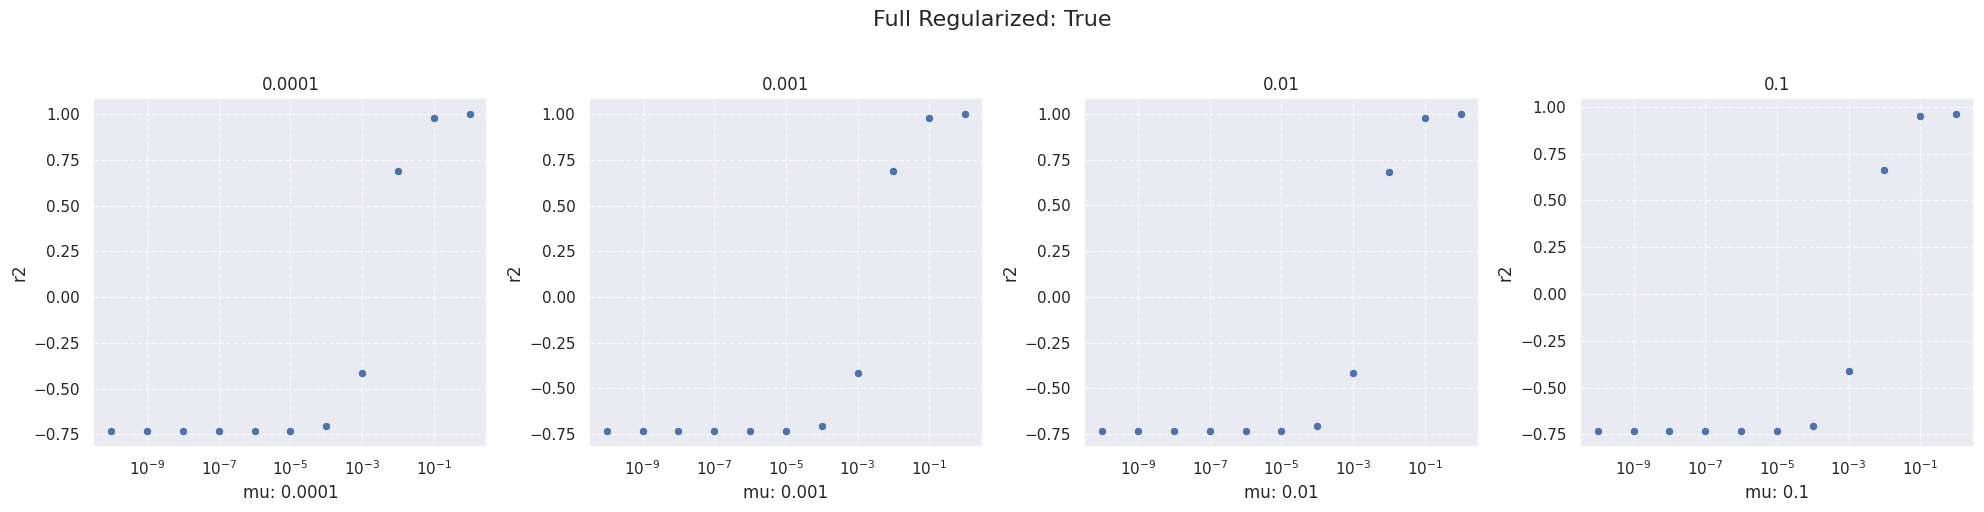

In [135]:
x = np.logspace(-10, 0, num=11)
y = np.array(r2_values[:55]).reshape(5, -1)
fig, ax = plt.subplots(1, 4, figsize=(20,5))
name = [1e-4, 1e-3, 1e-2, 1e-1, 1e0]
plt.title('regularized: False')
for j in range(4):
  sns.scatterplot(x = x, y = y[j], ax=ax[j])
  ax[j].set_xscale('log')
  ax[j].set_ylabel('r2')
  ax[j].set_xlabel(f'mu: {name[j]}')
  ax[j].grid(True, linestyle='--', alpha=0.7)
  ax[j].set_title(name[j])
fig.suptitle('Full Regularized: True', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

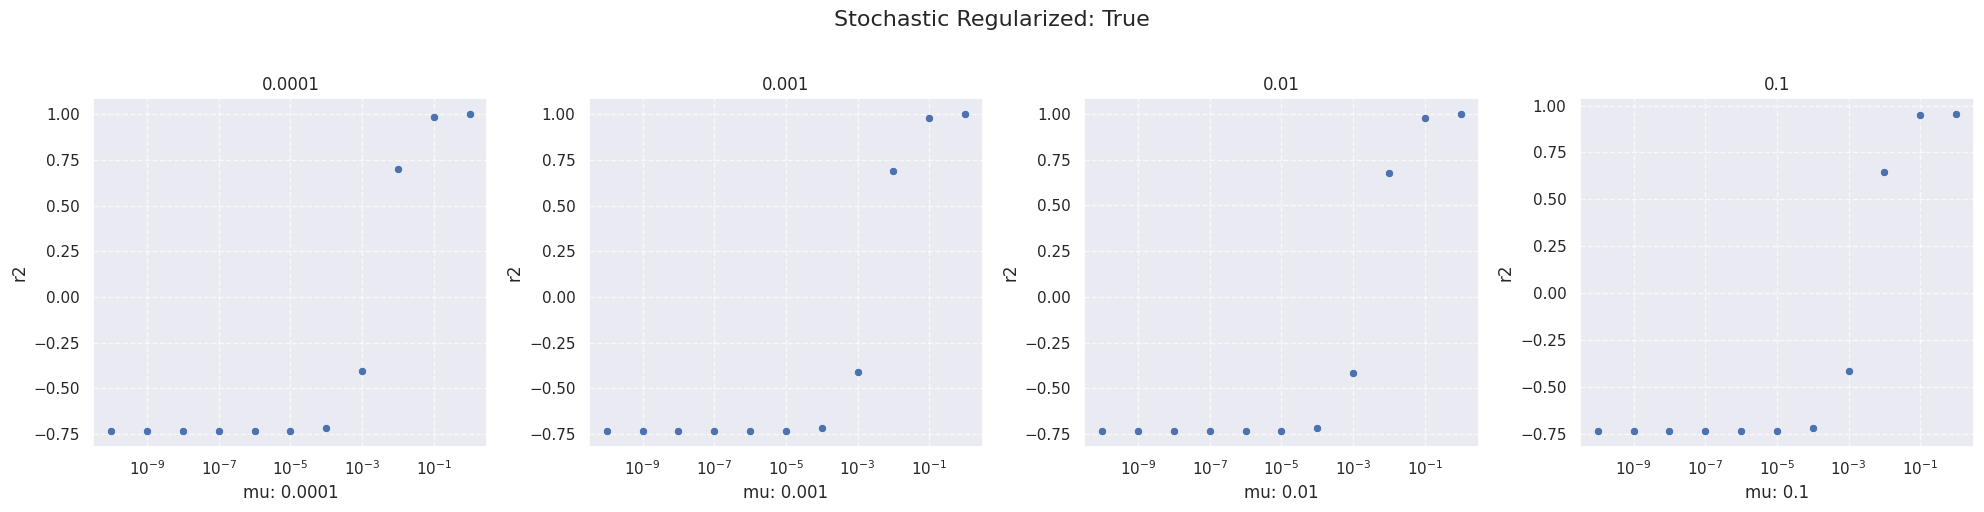

In [136]:
x = np.logspace(-10, 0, num=11)
y = np.array(r2_values[55:110]).reshape(5, -1)
fig, ax = plt.subplots(1, 4, figsize=(20,5))
name = [1e-4, 1e-3, 1e-2, 1e-1, 1e0]
plt.title('regularized: False')
for j in range(4):
  sns.scatterplot(x = x, y = y[j], ax=ax[j])
  ax[j].set_xscale('log')
  ax[j].set_ylabel('r2')
  ax[j].set_xlabel(f'mu: {name[j]}')
  ax[j].grid(True, linestyle='--', alpha=0.7)
  ax[j].set_title(name[j])
fig.suptitle('Stochastic Regularized: True', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

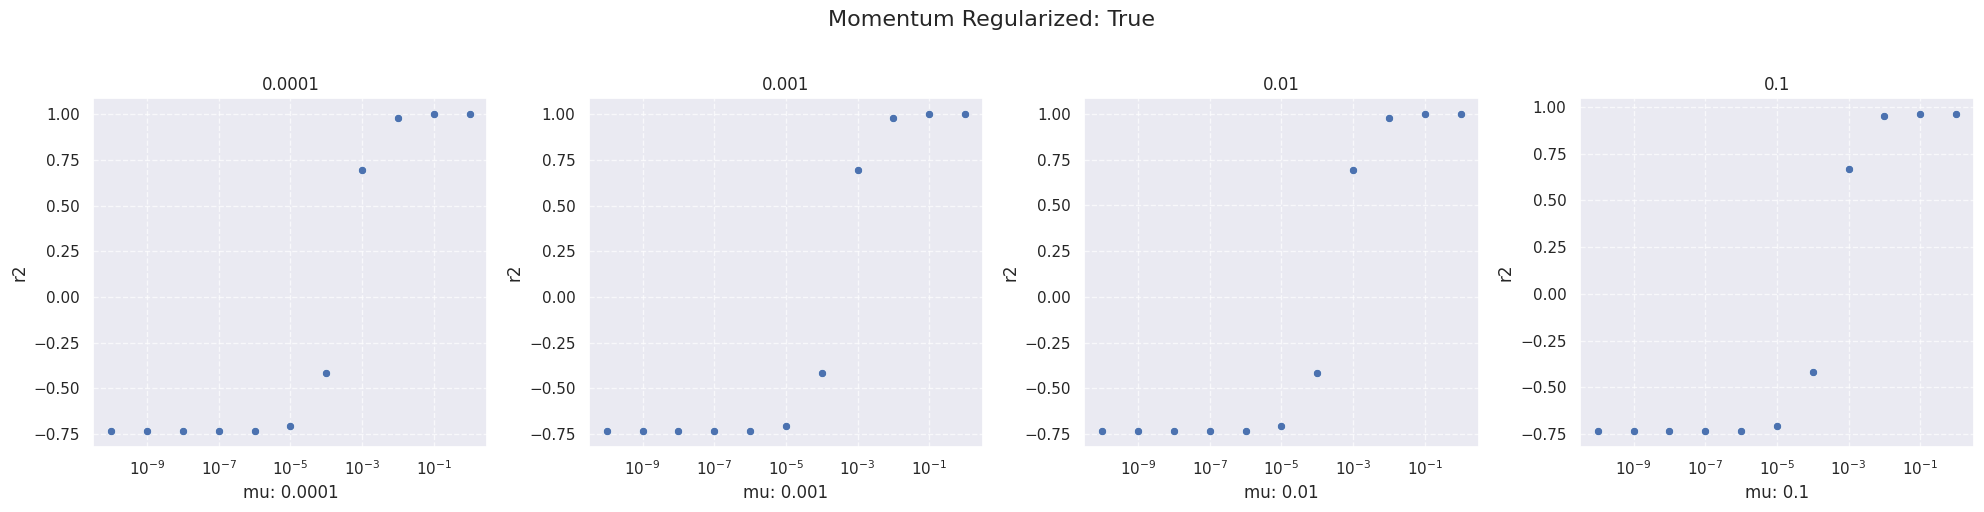

In [137]:
x = np.logspace(-10, 0, num=11)
y = np.array(r2_values[110:165]).reshape(5, -1)
fig, ax = plt.subplots(1, 4, figsize=(20,5))
name = [1e-4, 1e-3, 1e-2, 1e-1, 1e0]
plt.title('regularized: False')
for j in range(4):
  sns.scatterplot(x = x, y = y[j], ax=ax[j])
  ax[j].set_xscale('log')
  ax[j].set_ylabel('r2')
  ax[j].set_xlabel(f'mu: {name[j]}')
  ax[j].grid(True, linestyle='--', alpha=0.7)
  ax[j].set_title(name[j])
fig.suptitle('Momentum Regularized: True', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [2]:

lambdas = np.logspace(-6,-1, 7)

NameError: name 'np' is not defined

In [90]:
methods = ['full','stochastic','momentum','adam', 'descent']
for lambda_ in lambdas:
      descent_config = {
              'descent_name': method,  # Название метода: 'full', 'stochastic', 'momentum', 'adam'
              'regularized': False,    # Указать, использовать ли регуляризацию
              'kwargs': {              # Дополнительные параметры для метода
              'dimension': X_train.shape[1],  # Размерность входных данных
              'lambda_': lambda_,
              'mu': mu                        # Текущее значение learning rate
              }}

      model = get_descent(descent_config)

      max_iter = 1000
      tolerance = 1e-5
      for iter in range(max_iter):
        gradient = model.calc_gradient(X_val, y_val)
        delta_w = model.update_weights(gradient)
        if np.linalg.norm(delta_w) < tolerance:
          break
        #print(f"np.linalg.norm(delta_w): {np.linalg.norm(delta_w)}")
      y_val_pred = model.predict(X_val)
      r2 = r2_score(y_val, y_val_pred)
      r2_dat_reg.append(r2)
      print(f"method: {descent_config.get('descent_name')}, r2: {r2}, lambda: {lambda_}, mu: {mu}")

method: adam, r2: -0.7306739693393005, lambda: 1e-06, mu: 1e-08
method: adam, r2: -0.7307104834329641, lambda: 1e-05, mu: 1e-08
method: adam, r2: -0.730700674964861, lambda: 0.0001, mu: 1e-08
method: adam, r2: -0.7306483984853875, lambda: 0.001, mu: 1e-08
method: adam, r2: -0.7317683814788634, lambda: 0.01, mu: 1e-08
method: adam, r2: -0.730751932230284, lambda: 1e-06, mu: 1e-07
method: adam, r2: -0.7308852035961939, lambda: 1e-05, mu: 1e-07
method: adam, r2: -0.7307175337874403, lambda: 0.0001, mu: 1e-07
method: adam, r2: -0.7306371891310368, lambda: 0.001, mu: 1e-07
method: adam, r2: -0.7319617142133925, lambda: 0.01, mu: 1e-07
method: adam, r2: -0.730741669321965, lambda: 1e-06, mu: 1e-06
method: adam, r2: -0.7306992335679197, lambda: 1e-05, mu: 1e-06
method: adam, r2: -0.7308246148443374, lambda: 0.0001, mu: 1e-06
method: adam, r2: -0.7307801073004871, lambda: 0.001, mu: 1e-06
method: adam, r2: -0.7317804511526826, lambda: 0.01, mu: 1e-06
method: adam, r2: -0.731057856643593, lambd

In [141]:
r2_dat = []

In [30]:
lambdas = np.logspace(-6,-1, 6)

In [44]:
methods = ['full','stochastic','momentum','descent']

In [27]:
Lossnames = ['LossFunction.MSE', 'LossFunction.MAE', 'LossFunction.LogCosh', 'LossFunction.Huber']

In [142]:
for Lossname in Lossnames:
 for method in methods:
  for lambda_ in lambdas:
    descent_config = {
            'descent_name': method,  # Название метода: 'full', 'stochastic', 'momentum', 'adam'
            'regularized': False,    # Указать, использовать ли регуляризацию
            'kwargs': {              # Дополнительные параметры для метода
            'dimension': X_train.shape[1],  # Размерность входных данных
            'lambda_': lambda_,
            'loss_function': Lossname
              # Текущее значение learning rate
             }}

    model = get_descent(descent_config)

    max_iter = 1000
    tolerance = 0.01
    for iter in range(max_iter):
      gradient = model.calc_gradient(X_val, y_val)
      delta_w = model.update_weights(gradient)
      if np.linalg.norm(delta_w) < tolerance:
        break

    y_val_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_val_pred)
    r2_dat.append(r2)
    print(f"method: {method}, r2: {r2}, lambda: {lambda_}, loss: {Lossname}")

method: full, r2: -0.7306360179702045, lambda: 1e-06, loss: LossFunction.MSE
method: full, r2: -0.7279834943579053, lambda: 1e-05, loss: LossFunction.MSE
method: full, r2: -0.6804410213474683, lambda: 0.0001, loss: LossFunction.MSE
method: full, r2: -0.2955329916075742, lambda: 0.001, loss: LossFunction.MSE
method: full, r2: 0.8073877971801225, lambda: 0.01, loss: LossFunction.MSE
method: full, r2: 0.9909647962665129, lambda: 0.1, loss: LossFunction.MSE
method: stochastic, r2: -0.7305766906493234, lambda: 1e-06, loss: LossFunction.MSE
method: stochastic, r2: -0.729058319586571, lambda: 1e-05, loss: LossFunction.MSE
method: stochastic, r2: -0.6800834253040708, lambda: 0.0001, loss: LossFunction.MSE
method: stochastic, r2: -0.3017741396201279, lambda: 0.001, loss: LossFunction.MSE
method: stochastic, r2: 0.8033681281927796, lambda: 0.01, loss: LossFunction.MSE
method: stochastic, r2: 0.9906075153672154, lambda: 0.1, loss: LossFunction.MSE
method: momentum, r2: -0.7284272827179379, lambda

In [146]:
np.array(r2_dat[:24]).reshape(4, -1)

array([[-0.73063602, -0.72798349, -0.68044102, -0.29553299,  0.8073878 ,
         0.9909648 ],
       [-0.73057669, -0.72905832, -0.68008343, -0.30177414,  0.80336813,
         0.99060752],
       [-0.72842728, -0.68041571, -0.29643938,  0.81070419,  0.99126863,
         0.9999057 ],
       [-0.73056301, -0.72046151, -0.63171325,  0.01782035,  0.91166555,
         0.9985701 ]])

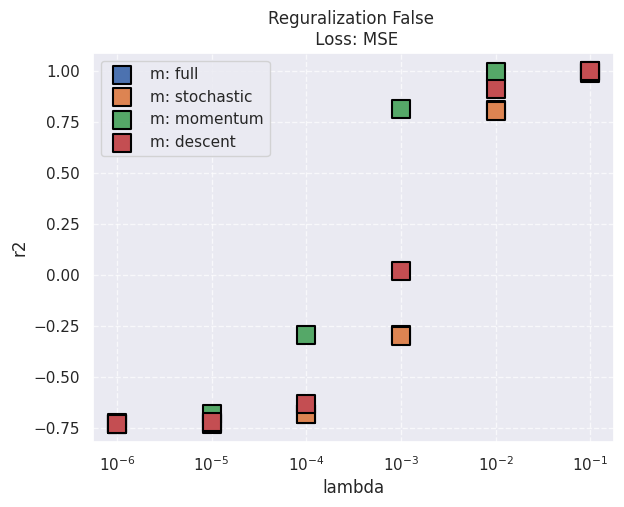

In [155]:
x = np.logspace(-6, -1, num=6)
y = np.array(r2_dat[:24]).reshape(4, -1)
markers = ['o', 's', 'd', '*', 'x', 'v']
for i in range(y.shape[0]):
  sns.scatterplot(x=x, y=y[i], label=f'm: {methods[i]}', s=150, marker='s', edgecolor='black', linewidth=1.5)
plt.xscale('log')
plt.xlabel('lambda')
plt.ylabel('r2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.title('Reguralization False \n Loss: MSE')
plt.legend()
plt.show()

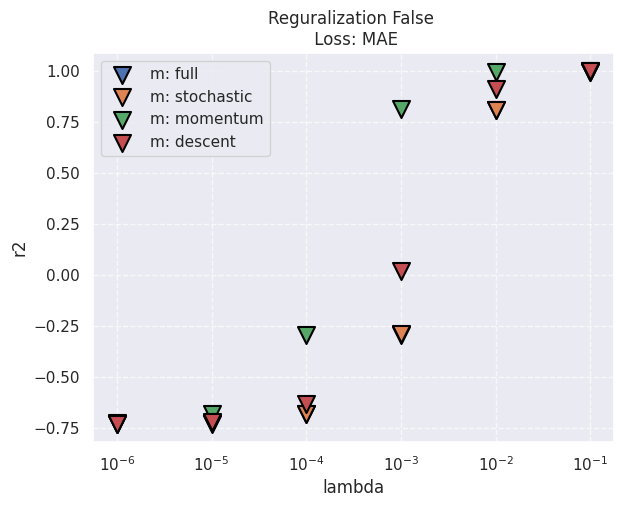

In [156]:
x = np.logspace(-6, -1, num=6)
y = np.array(r2_dat[24:48]).reshape(4, -1)
markers = ['o', 's', 'd', '*', 'x', 'v']
for i in range(y.shape[0]):
  sns.scatterplot(x=x, y=y[i], label=f'm: {methods[i]}', s=150, marker='v', edgecolor='black', linewidth=1.5)
plt.xscale('log')
plt.xlabel('lambda')
plt.ylabel('r2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.title('Reguralization False \n Loss: MAE')
plt.legend()
plt.show()

In [101]:
print(np.array(r2_dat[48:72]).reshape(4, -1))

[[-0.730346   -0.73050938 -0.7056451  -0.29562095  0.8074135   0.99096469]
 [-0.73041137 -0.73079961 -0.71574484 -0.30168457  0.80111893  0.99082528]
 [-0.73065413 -0.70541638 -0.29658488  0.81066753  0.99126745  0.99990573]
 [-0.73074452 -0.73002191 -0.63180606  0.01766066  0.91165189  0.99857029]]


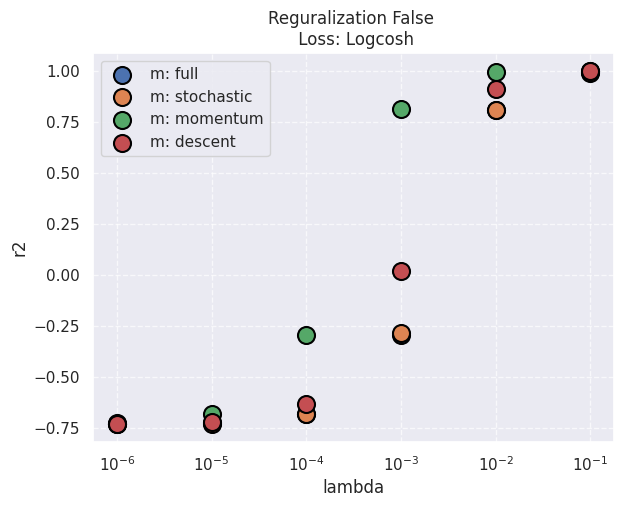

In [157]:
x = np.logspace(-6, -1, num=6)
y = np.array(r2_dat[48:72]).reshape(4, -1)
markers = ['o', 's', 'd', '*', 'x', 'v']
for i in range(y.shape[0]):
  sns.scatterplot(x=x, y=y[i], label=f'm: {methods[i]}', s=150, marker='o', edgecolor='black', linewidth=1.5)
plt.xscale('log')
plt.ylabel('r2')
plt.xlabel('lambda')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.title('Reguralization False \n Loss: Logcosh')
plt.legend()
plt.show()

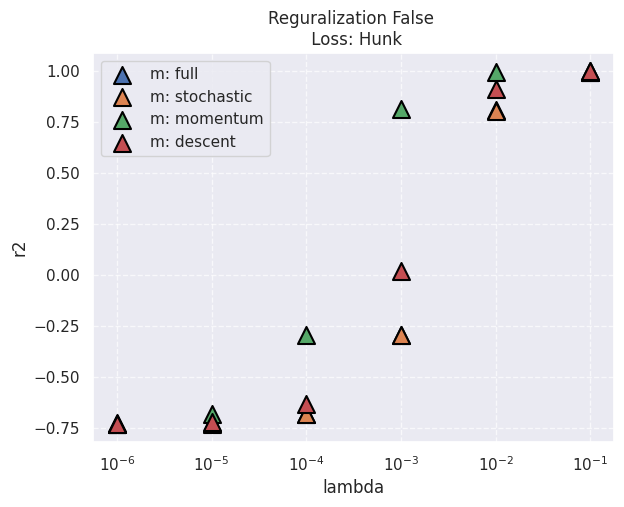

In [158]:
x = np.logspace(-6, -1, num=6)
y = np.array(r2_dat[72:96]).reshape(4, -1)
markers = ['o', 's', 'd', '*', 'x', 'v']
for i in range(y.shape[0]):
  sns.scatterplot(x=x, y=y[i], label=f'm: {methods[i]}', s=150, marker='^', edgecolor='black', linewidth=1.5)
plt.xscale('log')
plt.ylabel('r2')
plt.xlabel('lambda')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.title('Reguralization False \n Loss: Hunk')
plt.legend()
plt.show()